In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn import metrics

In [2]:
data = pd.read_csv("/content/spam.csv", encoding='latin-1') # Change the encoding to 'latin-1' or other appropriate encoding

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# Dropping the redundent looking collumns (for this project)

data = data.drop(data[['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']], axis=1)
# Renaming the columns because I feel fancy today
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


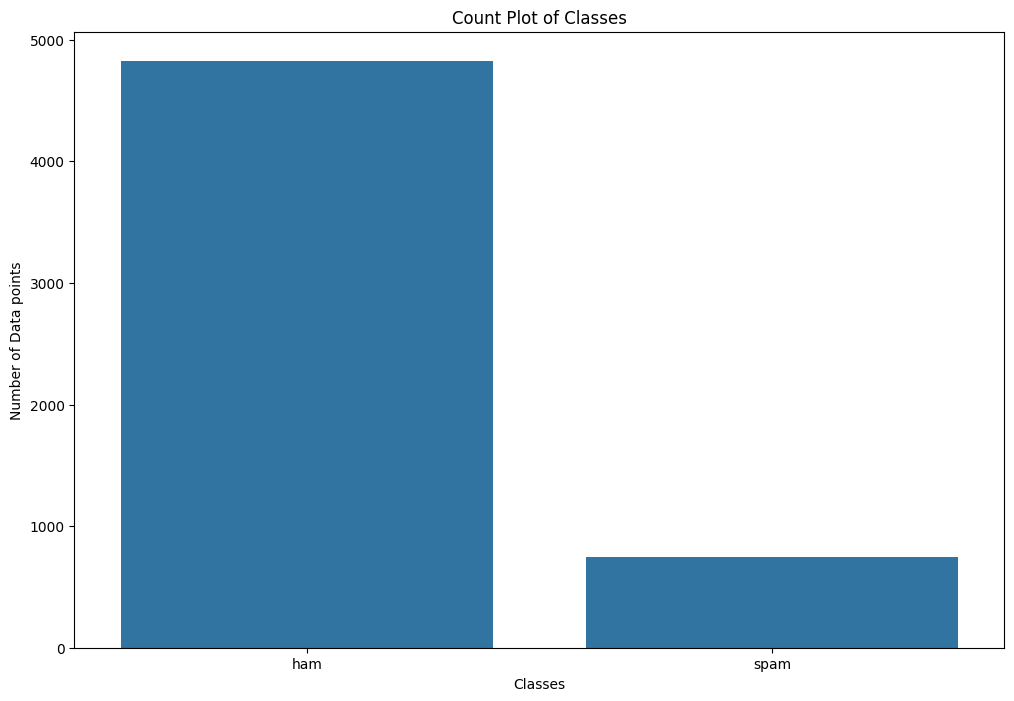

In [6]:
#Palette
#cols= ["#E1F16B", "#E598D8"]
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
sns.countplot(x= data["Target"])
plt.title("Count Plot of Classes")
plt.xlabel("Classes")
plt.ylabel("Number of Data points")
plt.show()

In [7]:
import nltk
nltk.download('punkt_tab')

data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


<Figure size 1200x800 with 0 Axes>

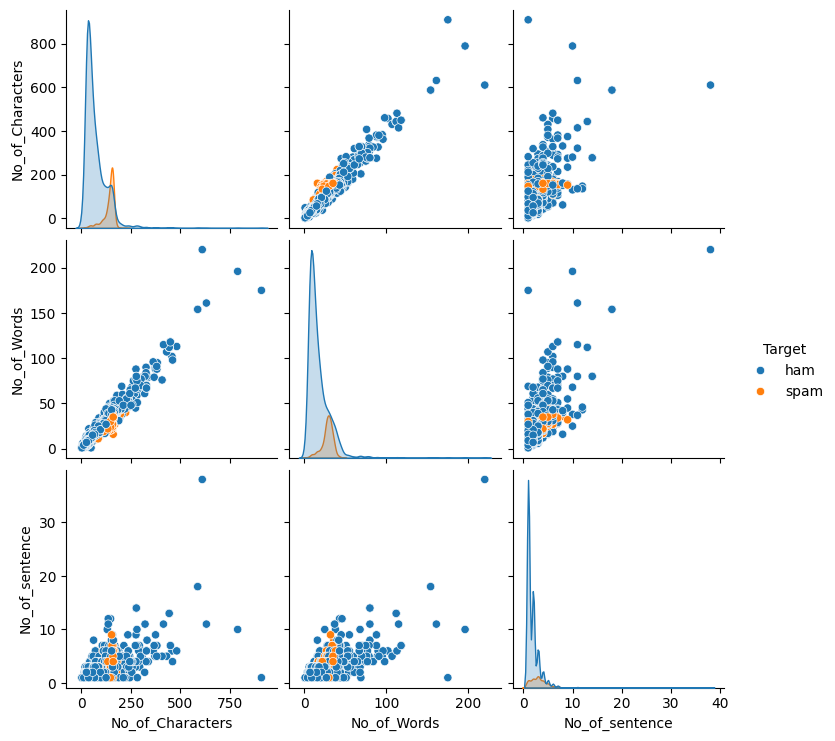

In [8]:
plt.figure(figsize=(12,8))
sns.pairplot(data=data, hue="Target")
plt.show()

In [9]:
#Dropping the outliers.
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

<Figure size 1200x800 with 0 Axes>

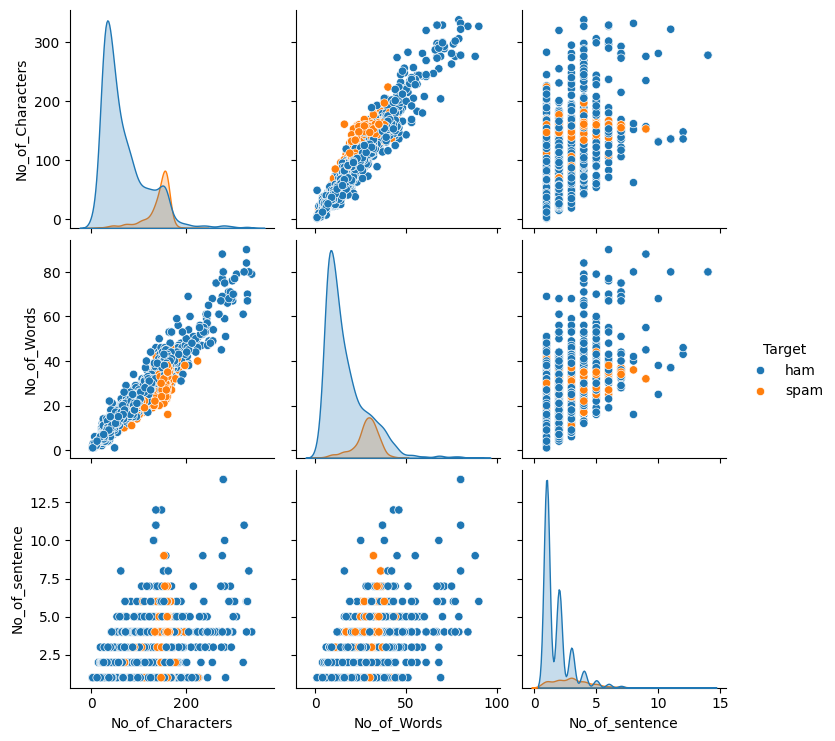

In [10]:
plt.figure(figsize=(12,8))
sns.pairplot(data=data, hue="Target")
plt.show()

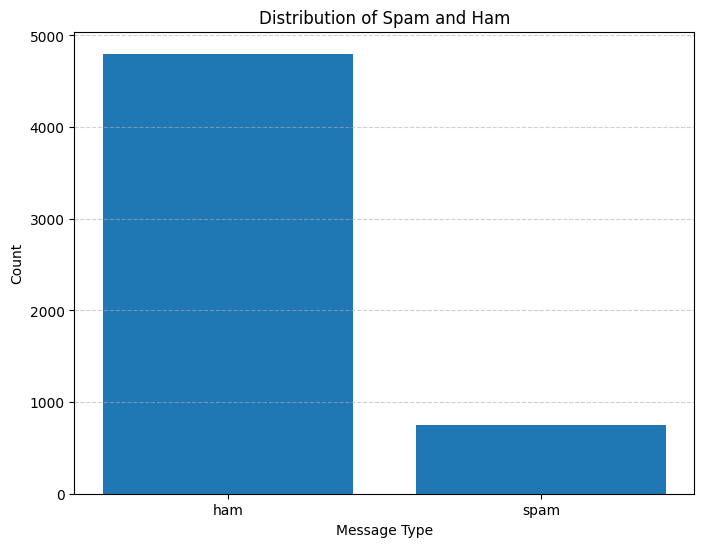

In [11]:
# Bar chart showing spam vs ham
plt.figure(figsize=(8,6))
class_counts = data['Target'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.title("Distribution of Spam and Ham")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


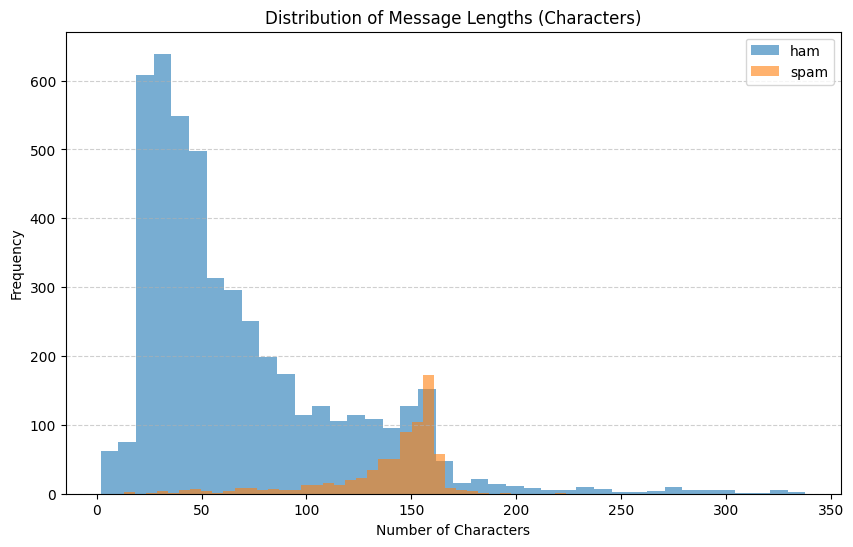

In [13]:
# Histogram for number of characters
plt.figure(figsize=(10,6))
for label in (data['Target'].unique()):
    subset = data[data['Target'] == label]
    plt.hist(subset["No_of_Characters"], bins=40, alpha=0.6, label=label)

plt.title("Distribution of Message Lengths (Characters)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


<Figure size 800x600 with 0 Axes>

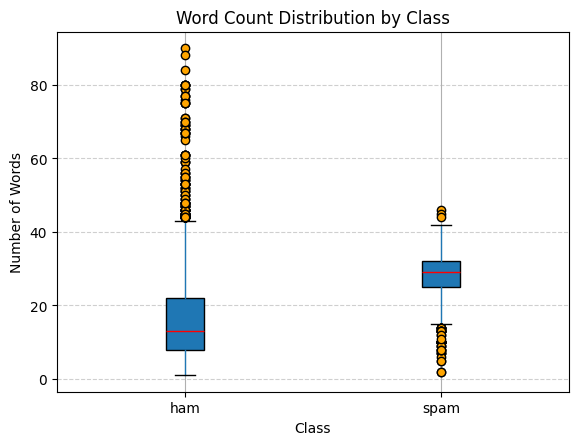

In [14]:
# Boxplot using matplotlib
plt.figure(figsize=(8,6))
data.boxplot(column='No_of_Words', by='Target', patch_artist=True,
             boxprops=dict(color='black'),
             medianprops=dict(color='red'),
             flierprops=dict(markerfacecolor='orange', marker='o'))

plt.title("Word Count Distribution by Class")
plt.suptitle("")  # Remove the automatic 'Boxplot grouped by...'
plt.xlabel("Class")
plt.ylabel("Number of Words")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


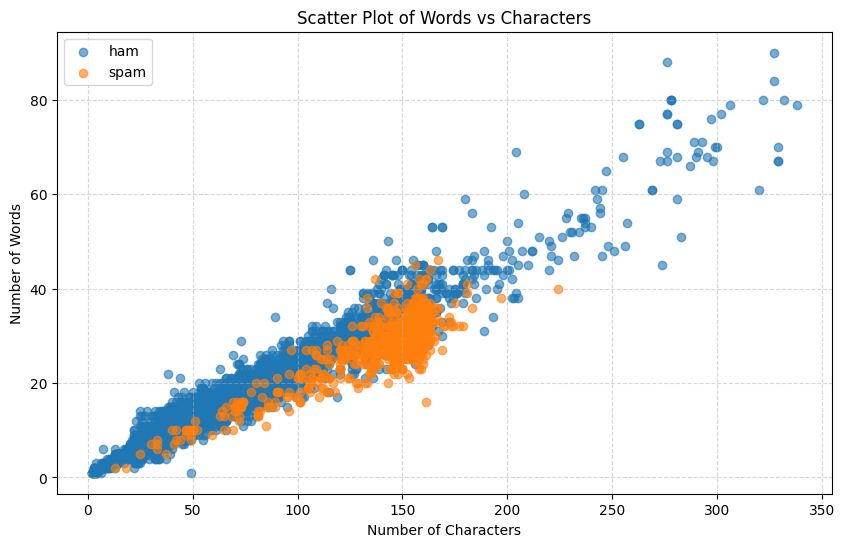

In [15]:
# Scatter plot of No_of_Words vs No_of_Characters
plt.figure(figsize=(10,6))

for label in data['Target'].unique():
    subset = data[data['Target'] == label]
    plt.scatter(subset['No_of_Characters'], subset['No_of_Words'],
                 label=label, alpha=0.6)

plt.title("Scatter Plot of Words vs Characters")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Words")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


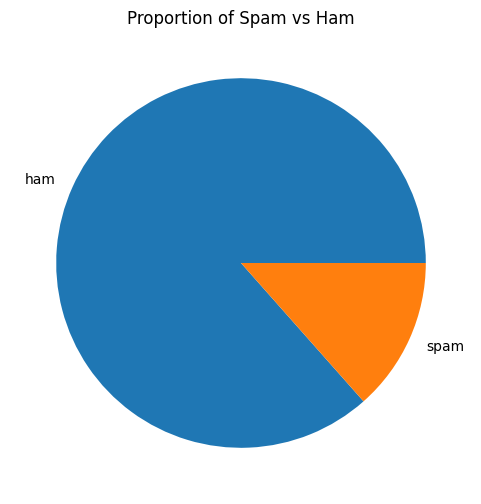

In [16]:
# Pie chart
plt.figure(figsize=(6,6))
sizes = class_counts.values
labels = class_counts.index
plt.pie(sizes, labels=labels)

plt.title("Proportion of Spam vs Ham")
plt.show()


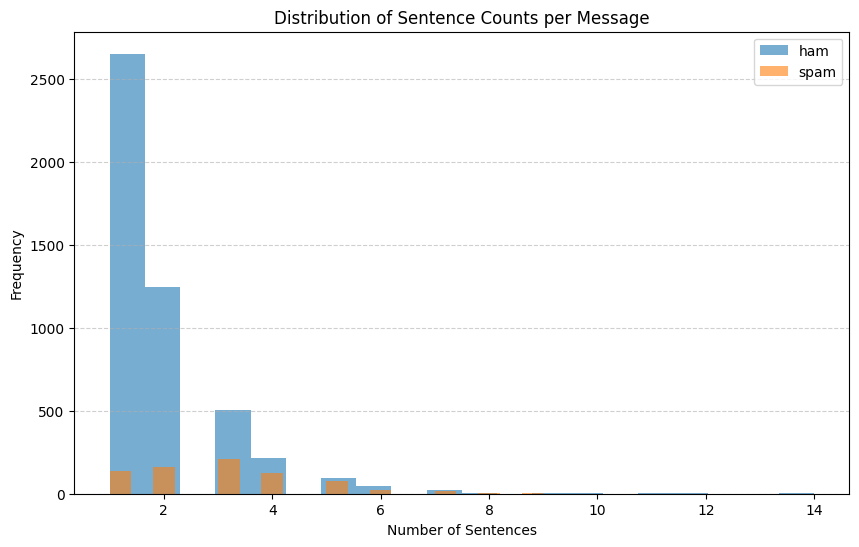

In [18]:
# Histogram of number of sentences
plt.figure(figsize=(10,6))
for label in (data['Target'].unique()):
    subset = data[data['Target'] == label]
    plt.hist(subset["No_of_sentence"], bins=20, alpha=0.6, label=label)

plt.title("Distribution of Sentence Counts per Message")
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


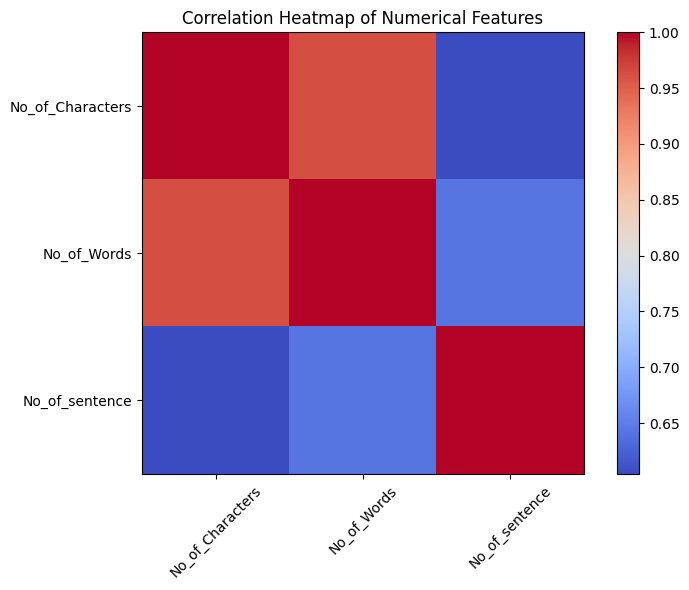

In [19]:
# Correlation matrix for numerical features
plt.figure(figsize=(8,6))
numerical_features = data[["No_of_Characters", "No_of_Words", "No_of_sentence"]]
correlation = numerical_features.corr()

plt.imshow(correlation, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation)), correlation.columns, rotation=45)
plt.yticks(range(len(correlation)), correlation.columns)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


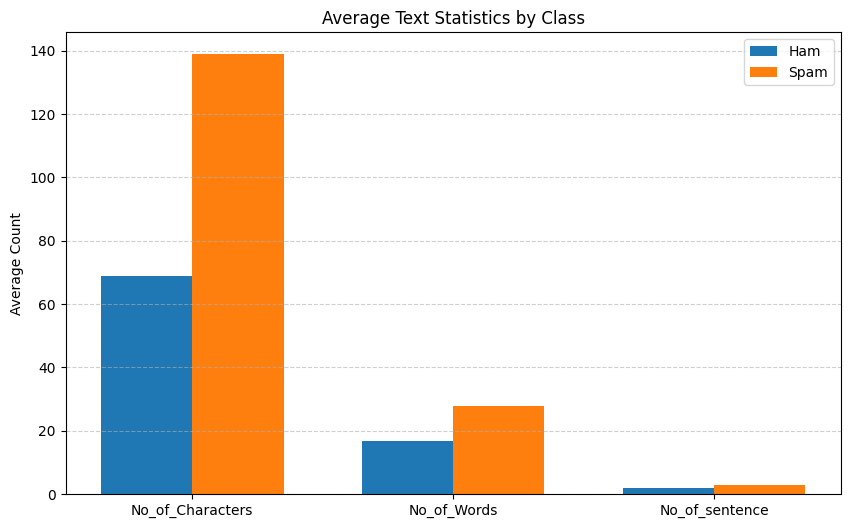

In [20]:
# Average stats per class
mean_stats = data.groupby("Target")[["No_of_Characters", "No_of_Words", "No_of_sentence"]].mean()

x = np.arange(len(mean_stats.columns))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, mean_stats.loc["ham"], width, label='Ham')
plt.bar(x + width/2, mean_stats.loc["spam"], width, label='Spam')

plt.xticks(x, mean_stats.columns)
plt.ylabel('Average Count')
plt.title('Average Text Statistics by Class')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


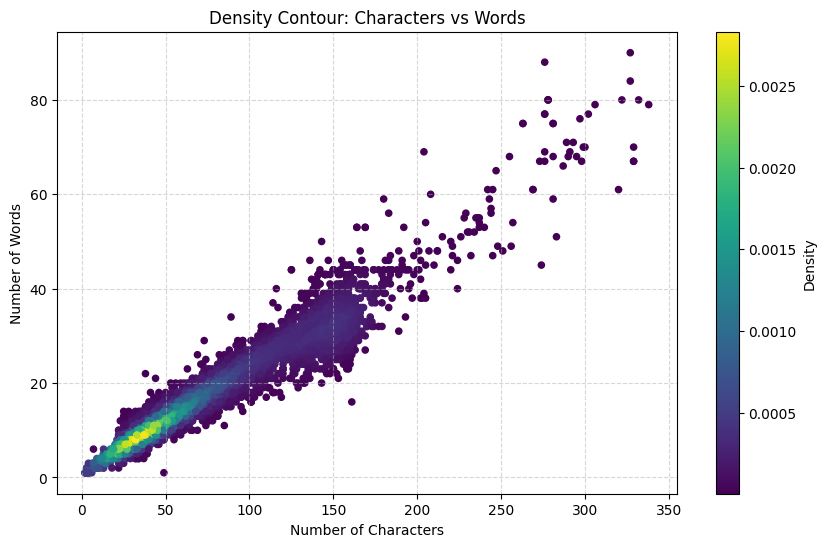

In [21]:
# Density contour plot
from scipy.stats import gaussian_kde

plt.figure(figsize=(10,6))
x = data["No_of_Characters"]
y = data["No_of_Words"]

xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, c=z, s=20, cmap='viridis')
plt.title("Density Contour: Characters vs Words")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Words")
plt.colorbar(label='Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [22]:
def clean_text(text):
  cleaned = re.sub("^a-zA-Z", '', text)
  cleaned = cleaned.lower()
  cleaned = cleaned.split()
  cleaned = ''.join(cleaned)
  return cleaned

data['Cleaned_text'] = data['Text'].apply(clean_text)


In [28]:
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
  tokens = word_tokenize(text)
  tokens = [token for token in tokens if token not in stop_words]
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return tokens

data['Tokenized_text'] = data['Cleaned_text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [31]:
vectorizer = TfidfVectorizer()
data['Tokenized_text'] = data['Tokenized_text'].apply(lambda tokens: ' '.join(tokens))
x = vectorizer.fit_transform(data['Tokenized_text'])

In [32]:
encoder = LabelEncoder()
data['Target'] = encoder.fit_transform(data['Target'])
y = data['Target']

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Accuracy of MultinomialNB() is 0.9243243243243243
Accuracy of SVC() is 0.9315315315315316
Accuracy of RandomForestClassifier() is 0.9522522522522523


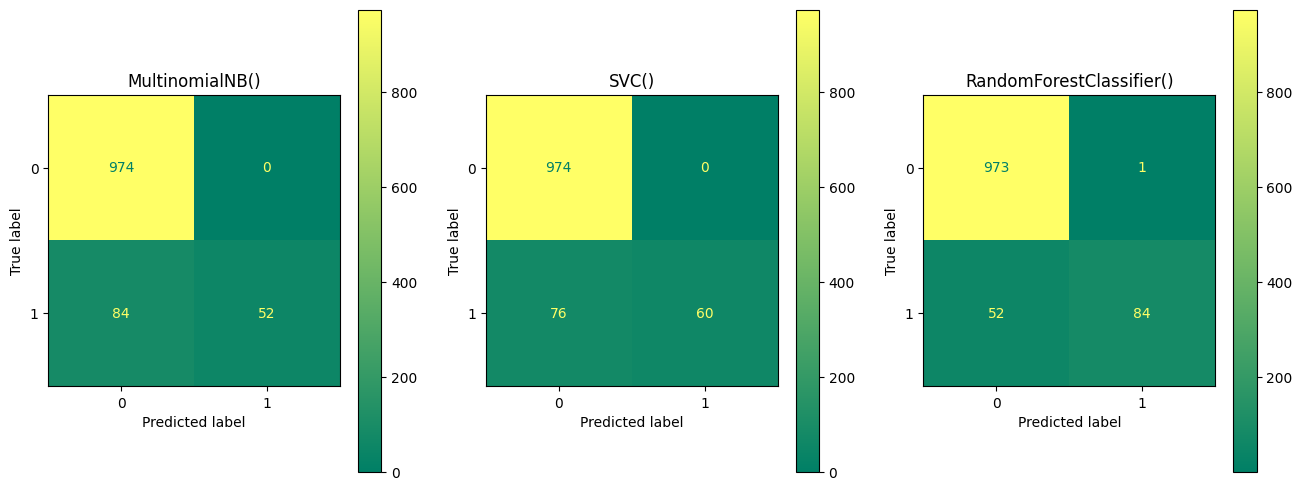

In [57]:
plt.figure(figsize=(16,6))

classifiers = [MultinomialNB(), SVC(), RandomForestClassifier()]
for i, classifier in enumerate(classifiers):
  classifier.fit(x_train, y_train)
  predictions = classifier.predict(x_test)
  accuracy = metrics.accuracy_score(y_test, predictions)
  print('Accuracy of '+str(classifier)+' is '+str(accuracy))
  precision = metrics.precision_score(y_test, predictions)
  recall = metrics.recall_score(y_test, predictions)
  f1_score = metrics.f1_score(y_test, predictions)
  ax = plt.subplot(1, 3, i + 1)
  metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax=ax, cmap='summer')
  ax.set_title(classifier)

plt.show()

